# Notebook de filtro colaborativo

En esta notebook estan los experimentos realizados de los modelos de filtrado 
colaborativo. El que se probó a fondo y se terminó implementado es el de la 
libreria implicit. Se recomienda ir a esa sección, ya que se hizo un lindo 
laburo de fine tunning (incluso una implementación de 5 fold CV que la lib no
tenia).

La libreria tiene varios modelos y se optimizaron 3 a los que se les dedico
bastante tiempo. Hay algunos plots incluso del modelo final elegido.

## Setup inicial


In [1]:
import sqlite3
import pandas as pd
import os
import sklearn as sk
from sklearn import model_selection, ensemble, metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

In [2]:
THIS_FOLDER = os.path.dirname(os.path.abspath("__file__"))
print(THIS_FOLDER)

# tables
interacciones = 'interactions'
items = 'repositories'
users = 'users'

# datasets to dfs
con = sqlite3.connect(os.path.join(THIS_FOLDER, "data/data.db"))
df_int = pd.read_sql_query(f"SELECT * FROM {interacciones}", con)
df_items = pd.read_sql_query(f"SELECT * FROM {items}", con)
df_users = pd.read_sql_query(f"SELECT * FROM {users}", con)
con.close()

/home/tomas/workspace/uba/sr/sr-tpfinal-gh-web


# Generics


In [3]:
def build_dummies(data, column, sep=";", remove_original_column=False):
    data_dummies = data[column].str.get_dummies(sep=sep)
    data_with_dummies = pd.concat([data, data_dummies], axis=1)
    if remove_original_column:
        data_with_dummies = data_with_dummies.drop(columns=[column], axis=1)
    return data_with_dummies


# Surprise

Enfoque de recomendación con surprise no es posible dado que no se enfoca en recomendaciones binarias

ver: https://github.com/NicolasHug/Surprise/issues/412

# Implicit

Libreria enfocada en recomendación binaria e implicita

In [1]:
import implicit
import numpy as np
from implicit import evaluation
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import bm25_weight, BM25Recommender
from implicit.nearest_neighbours import tfidf_weight, TFIDFRecommender

In [5]:
def make_df_for_implicit(df):
    """
    Clean columns and dropna for implicit models
    
    return a copy of original df
    """
    try:
        df = df.drop(columns=["index", "date"])
    except:
        pass
    # Eliminar usuarios e interacciónes mal armadas
    #list_null_repos = list(df_int[df_int["repository"].isnull()].index)
    #print(df_int.shape)
    #print(df_int.dropna().shape)
    df = df.dropna()
    # controlar que no hay nulls
    #dfint.isnull().sum()
    return df.copy()

In [6]:
def make_coo_matrix_from_df(df):
    df["users"] = df.user.astype("category")#.unique()
    df["repos"] = df.repository.astype("category")#.unique()
    
    return coo_matrix((np.ones(df.shape[0]),
                (df['repos'].cat.codes.copy(),
                df['users'].cat.codes.copy())))

In [7]:
dfint = make_df_for_implicit(df_int)
stars = make_coo_matrix_from_df(dfint)
stars_train, stars_test = sk.model_selection.train_test_split(stars, test_size=0.2, random_state=42)

In [8]:
stars_train

<944x12955 sparse matrix of type '<class 'numpy.float64'>'
	with 136255 stored elements in Compressed Sparse Row format>

In [9]:
stars_bm25 = bm25_weight(stars_train)
stars_by_users = stars_bm25.T.tocsr()
stars_by_users

<12955x944 sparse matrix of type '<class 'numpy.float64'>'
	with 136255 stored elements in Compressed Sparse Row format>

In [10]:
import threadpoolctl
threadpoolctl.threadpool_limits(1, "blas")

model = AlternatingLeastSquares(factors=64, regularization=0.05, alpha=2.0)
model.fit(stars_by_users)

/home/tomas/workspace/uba/sr/sr-tpfinal-gh-web/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
# make recomendation
userid = 'fly51fly'
codeid = dfint['users'].cat.categories.get_loc(userid)
#items_ids, items_scores = model.recommend(codeid, stars_by_users[codeid], N=10, filter_already_liked_items=False)
items_ids, items_scores = model.recommend(codeid, stars_by_users[codeid], N=10, filter_already_liked_items=True)

In [12]:
pd.DataFrame({"repos": dfint['repos'].cat.categories[items_ids], "scores": items_scores})

,repos,scores
0,KnowingNothing/compiler-and-arch,1.066684
1,Sayi/poi-tl,0.904436
2,palash1992/GEM,0.896956
3,markfink/nest2D,0.896649
4,f4exb/sdrangel,0.860464
5,YatSenOS/YatSenOS-Tutorial-Volume-1,0.742732
6,kyamagu/mexopencv,0.733498
7,justinas/nixos-ha-kubernetes,0.712311
8,Qihoo360/pink,0.702236
9,SmirkCao/Lihang,0.691942


In [13]:
# similar items
repoid = 'pytorch/pytorch'
coderepoid = dfint['repos'].cat.categories.get_loc(repoid)

similar_items_ids, similar_items_scores = model.similar_items(coderepoid)
pd.DataFrame({"repos": dfint['repos'].cat.categories[similar_items_ids], "scores": similar_items_scores})

,repos,scores
0,pytorch/pytorch,1.000000
1,facebookincubator/fbjni,0.483940
2,amitness/learning,0.458050
3,Significant-Gravitas/AutoGPT,0.416904
4,ewenme/ghibli,0.404739
5,banditml/banditml,0.396044
6,mikespook/Learning-Go-zh-cn,0.350081
7,GokuMohandas/Made-With-ML,0.329757
8,rmcelreath/stat_rethinking_2022,0.318124
9,jphall663/awesome-machine-learning-interpretab...,0.311982


In [14]:
# similar users
userid = 'fly51fly'
codeuserid = dfint['users'].cat.categories.get_loc(userid)

similar_users_ids, similar_users_scores = model.similar_users(codeuserid)
pd.DataFrame({"users": dfint['users'].cat.categories[similar_users_ids], "scores": similar_users_scores})

,users,scores
0,fly51fly,1.000000
1,nikitavoloboev,0.774156
2,oudommeas,0.765529
3,romanofficial,0.763105
4,Sandalots,0.737973
5,ICLXL,0.689491
6,SantoshSrinivas79,0.635361
7,ericmm,0.634160
8,tchigher,0.625970
9,yibit,0.614946


In [15]:
# Evaluacion
#implicit.evaluation.ndcg_at_k(model, stars_train, stars_test, K=10, num_threads=8)
print(implicit.evaluation.precision_at_k(model, stars_by_users, stars_test, K=10, num_threads=8))
print(implicit.evaluation.ndcg_at_k(model, stars_by_users, stars_test, K=10, num_threads=8))


  0%|          | 0/237 [00:00<?, ?it/s]

0.01108433734939759


  0%|          | 0/237 [00:00<?, ?it/s]

0.010682678896554103


## optimization

La idea es probar varios recomendadores y quedarnos con el mejor.

In [16]:
import optuna
from functools import partial

In [17]:
# split train test
dfint = make_df_for_implicit(df_int)
#dfint = dfint.head(n=1000).copy()
stars_for_cv = make_coo_matrix_from_df(dfint)
stars_train, stars_test = sk.model_selection.train_test_split(stars_for_cv, test_size=0.9, random_state=42)

In [18]:
# no se usa
if False:
    stars_w = {
        "base": stars_train.T.tocsr(),
        "tfidf": tfidf_weight(stars_train).T.tocsr(),
        "bm25_v1": bm25_weight(stars_train).T.tocsr(),
        "bm25_v2": bm25_weight(stars_train, K1=50).T.tocsr(),
        "bm25_v3": bm25_weight(stars_train, B=0.7).T.tocsr(),
        "bm25_v4": bm25_weight(stars_train, K1=20).T.tocsr(),
    }

    # model fit
    for name, stars_by_users_w in stars_w.items():
        print(name)
        model = AlternatingLeastSquares(factors=64, regularization=0.05, alpha=2.0, random_state=42)
        model.fit(stars_by_users_w, show_progress=False)
        
        # metrics
        print(implicit.evaluation.precision_at_k(model, stars_by_users_w, stars_test, K=10, num_threads=8, show_progress=False))
        print(implicit.evaluation.ndcg_at_k(model, stars_by_users_w, stars_test, K=10, num_threads=8, show_progress=False))


Lo anterior parece indicar que no existen grandes diferencias entre usar uno u otro tipo de peso, usaremos BM25 por default.

Usaremos entonces optuna para explorar los HP de algúnos modelos de implicit

creditos del código: https://github.com/benfred/implicit/issues/572

In [19]:
# no se usa
if False:
    def k_fold_split(ratings, i):
        ratings = ratings.tocoo()

        step = np.round(ratings.data.shape[0]/5).astype(int)

        if i == 0:
            test = csr_matrix((ratings.data[:step], (ratings.row[:step], ratings.col[:step])),
                            shape=ratings.shape, dtype=ratings.dtype)

            train = csr_matrix((ratings.data[step:],
                            (ratings.row[step:], ratings.col[step:])),
                            shape=ratings.shape, dtype=ratings.dtype)

            test.data[test.data < 0] = 0
            test.eliminate_zeros()

        elif i == 1:
            include_range = np.arange(step, step*2).astype(int)
            test = csr_matrix((ratings.data[include_range], (ratings.row[include_range], ratings.col[include_range])),
                        shape=ratings.shape, dtype=ratings.dtype)
            
            train = csr_matrix((ratings.data[~np.isin(np.arange(len(ratings.data)), include_range)],
                            (ratings.row[~np.isin(np.arange(len(ratings.row)), include_range)],
                            ratings.col[~np.isin(np.arange(len(ratings.col)), include_range)])),
                            shape=ratings.shape, dtype=ratings.dtype)

            test.data[test.data < 0] = 0
            test.eliminate_zeros()

        elif i == 2:
            include_range = np.arange(step*2, step*3).astype(int)
            test = csr_matrix((ratings.data[include_range], (ratings.row[include_range], ratings.col[include_range])),
                        shape=ratings.shape, dtype=ratings.dtype)
            
            train = csr_matrix((ratings.data[~np.isin(np.arange(len(ratings.data)), include_range)],
                            (ratings.row[~np.isin(np.arange(len(ratings.row)), include_range)],
                            ratings.col[~np.isin(np.arange(len(ratings.col)), include_range)])),
                            shape=ratings.shape, dtype=ratings.dtype)

            test.data[test.data < 0] = 0
            test.eliminate_zeros()

        elif i == 3:
            include_range = np.arange(step*3, step*4).astype(int)
            test = csr_matrix((ratings.data[include_range], (ratings.row[include_range], ratings.col[include_range])),
                        shape=ratings.shape, dtype=ratings.dtype)
            
            train = csr_matrix((ratings.data[~np.isin(np.arange(len(ratings.data)), include_range)],
                            (ratings.row[~np.isin(np.arange(len(ratings.row)), include_range)],
                            ratings.col[~np.isin(np.arange(len(ratings.col)), include_range)])),
                            shape=ratings.shape, dtype=ratings.dtype)

            test.data[test.data < 0] = 0
            test.eliminate_zeros()

        elif i == 4:
            test = csr_matrix((ratings.data[step*4:], (ratings.row[step*4:], ratings.col[step*4:])),
                            shape=ratings.shape, dtype=ratings.dtype)

            train = csr_matrix((ratings.data[:step*4],
                            (ratings.row[:step*4], ratings.col[:step*4])),
                            shape=ratings.shape, dtype=ratings.dtype)

            test.data[test.data < 0] = 0
            test.eliminate_zeros()
        
        else:
            pass

        return train, test


    def objective_als(trial, data):
        als_factors        = trial.suggest_int('factors', 2, 15, step=1)
        als_regularization = trial.suggest_float('regularization', 0.00001, 1.0, log=True)
        #als_use_cg         = trial.suggest_categorical('use_cg', [True, False])
        als_iterations     = trial.suggest_int('iterations', 45, 80, step=5)
        
        model = AlternatingLeastSquares(
            factors        = als_factors,
            regularization = als_regularization,
            #use_cg         = als_use_cg,
            iterations     = als_iterations,
            random_state   = 42,
            num_threads    = 8
        )

        ## cross validation
        scores = []
        for i in range(5):
            analysis_data, assessment_data = k_fold_split(data, i)
            model.fit(analysis_data, show_progress=False)
            score = implicit.evaluation.ndcg_at_k(model, analysis_data, assessment_data, K=5, show_progress=False)
            # score = ndcg_at_k(model, analysis_data, assessment_data, K=5)
            # score = AUC_at_k(model, analysis_data, assessment_data, K=5)
            scores.append(score)
        
        return np.array(scores).mean()


    def objective_lmf(trial, data):
        lmf_factors        = trial.suggest_int('factors', 1000, 2000, step=5)
        lmf_regularization = trial.suggest_float('regularization', 0.1, 0.3, log=True)
        lmf_learning_rate  = trial.suggest_float('learning_rate', 0.45, 0.8, log=True)
        lmf_iterations     = trial.suggest_int('iterations', 5, 20, step=1)
        
        model = LogisticMatrixFactorization(
            factors        = lmf_factors,
            regularization = lmf_regularization,
            learning_rate  = lmf_learning_rate,
            iterations     = lmf_iterations,
            random_state   = 42,
            num_threads    = 8
        )

        ## cross validation
        scores = []
        for i in range(5):
            analysis_data, assessment_data = k_fold_split(data, i)
            model.fit(analysis_data, show_progress=False)
            score = implicit.evaluation.ndcg_at_k(model, analysis_data, assessment_data, K=5, show_progress=False)
            # score = ndcg_at_k(model, analysis_data, assessment_data, K=5)
            # score = AUC_at_k(model, analysis_data, assessment_data, K=5)
            scores.append(score)
        
        return np.array(scores).mean()

In [20]:
def objective_bpr(trial, train, valid):
    bpr_factors                 = trial.suggest_int('factors', 10, 2000, step=10)
    bpr_learning_rate           = trial.suggest_float('learning_rate', 0.00001, 1.0, log=True)
    bpr_regularization          = trial.suggest_float('regularization', 0.00001, 1.0, log=True)
    bpr_iterations              = trial.suggest_int('iterations', 10, 500, step=5)
    
    model = BayesianPersonalizedRanking(
        factors                 = bpr_factors,
        learning_rate           = bpr_learning_rate,
        regularization          = bpr_regularization,
        iterations              = bpr_iterations,
        #verify_negative_samples = bpr_verify_negative_samples,
        verify_negative_samples = False,
        random_state            = 42,
        num_threads             = 8
    )
    
    try:
        model.fit(train, show_progress=False)
    except:
        # a veces explota, no se porque
        pass
    
    return implicit.evaluation.ndcg_at_k(model, train, valid, K=5, show_progress=False)

def objective_als(trial, train, valid):
    als_factors        = trial.suggest_int('factors', 2, 240, step=1)
    als_regularization = trial.suggest_float('regularization', 0.00001, 1.0, log=True)
    #als_use_cg         = trial.suggest_categorical('use_cg', [True, False])
    als_iterations     = trial.suggest_int('iterations', 5, 150, step=5)
    
    model = AlternatingLeastSquares(
        factors        = als_factors,
        regularization = als_regularization,
        #use_cg         = als_use_cg,
        iterations     = als_iterations,
        random_state   = 42,
        num_threads    = 8
    )

    try:
        model.fit(train, show_progress=False)
    except:
        # a veces explota, no se porque
        pass
    
    return implicit.evaluation.ndcg_at_k(model, train, valid, K=5, show_progress=False)


def objective_lmf(trial, train, valid):
    lmf_factors        = trial.suggest_int('factors', 10, 2000, step=10)
    lmf_regularization = trial.suggest_float('regularization', 0.00001, 1.0, log=True)
    lmf_learning_rate  = trial.suggest_float('learning_rate', 0.00001, 1.0, log=True)
    lmf_iterations     = trial.suggest_int('iterations', 5, 150, step=5)
    
    model = LogisticMatrixFactorization(
        factors        = lmf_factors,
        regularization = lmf_regularization,
        learning_rate  = lmf_learning_rate,
        iterations     = lmf_iterations,
        random_state   = 42,
        num_threads    = 8
    )

    try:
        model.fit(train, show_progress=False)
    except:
        # a veces explota, no se porque
        pass
    
    return implicit.evaluation.ndcg_at_k(model, train, valid, K=5, show_progress=False)

In [21]:
#def objective_bpr_cv(trial, train):
#    ## cross validation
#    scores = []
#    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
#    for fold_idx, (train_idx, validation_idx) in enumerate(kfolds.split(train)):
#        train_data = train[train_idx]
#        valid_data = train[validation_idx]
#        score = objective_bpr(trial, train_data, valid_data)
#        scores.append(score)
#    return np.array(scores).mean()

#bpr_study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
#                                pruner=optuna.pruners.HyperbandPruner(),
#                                storage="sqlite:///db.sqlite3", # para optuna dashboard
#                                direction='maximize',
#                                #study_name='bpr_study_tune_cv_v1',
#                                #load_if_exists=True
#                                )
#objective_bpr_params = partial(objective_bpr_cv, train=stars_train)
#bpr_study.optimize(objective_bpr_params, n_trials=3000)
#
#als_study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
#                                pruner=optuna.pruners.HyperbandPruner(),
#                                storage="sqlite:///db.sqlite3", # para optuna dashboard
#                                direction='maximize',
#                                study_name='als_study_tune_v3',
#                                load_if_exists=True)
#objective_als_params = partial(objective_als, data=stars_train)
#als_study.optimize(objective_als_params, n_trials=300)
#
#lmf_study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
#                                pruner=optuna.pruners.HyperbandPruner(),
#                                storage="sqlite:///db.sqlite3", # para optuna dashboard
#                                direction='maximize',
#                                study_name='lmf_study_tune_v2',
#                                load_if_exists=True)
#objective_lmf_params = partial(objective_lmf, data=stars_train)
#lmf_study.optimize(objective_lmf_params, n_trials=2000)

A continuación creamos un pipeline para ejecutar todas las pruebas juntas

In [22]:
def objective_cv(trial, train, objective_func):
    ## cross validation
    scores = []
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold_idx, (train_idx, validation_idx) in enumerate(kfolds.split(train)):
        train_data = train[train_idx]
        valid_data = train[validation_idx]
        score = objective_func(trial, train_data, valid_data)
        scores.append(score)
    return np.array(scores).mean()

def objective_als_cv(trial, train):
    return objective_cv(trial, train, objective_als)

def objective_lmf_cv(trial, train):
    return objective_cv(trial, train, objective_lmf)

def objective_bpr_cv(trial, train):
    return objective_cv(trial, train, objective_bpr)

In [23]:
#N_TRIALS = 1000 # Descomentar para pruebas largas y exhaustivas
N_TRIALS = 10

models = {
    "als": {
        "name": "als",
        "objective": objective_als_cv,
        "n_trials": N_TRIALS,
        "best_params": None,
    },
    "lmf": {
        "name": "lmf",
        "objective": objective_lmf_cv,
        "n_trials": N_TRIALS,
        "best_params": None,
    },
    "bpr": {
        "name": "bpr",
        "objective": objective_bpr_cv,
        "n_trials": N_TRIALS,
        "best_params": None,
    },
}

version = 1
for model_id, params in models.items():
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
                pruner=optuna.pruners.HyperbandPruner(),
                storage="sqlite:///db.sqlite3", # para optuna dashboard
                direction='maximize',
                study_name=f'{params["name"]}_study_v{version}',
                load_if_exists=True)
    objective_params = partial(params["objective"], train=stars_train)
    study.optimize(objective_params, n_trials=params["n_trials"])
    models[model_id]["best_params"] = study.best_params
#version += 1

[I 2024-01-02 21:17:50,285] Using an existing study with name 'als_study_v1' instead of creating a new one.
[I 2024-01-02 21:18:18,010] Trial 64 finished with value: 0.0822716075402538 and parameters: {'factors': 159, 'regularization': 0.010415003283511644, 'iterations': 35}. Best is trial 16 with value: 0.1365615926860104.
[I 2024-01-02 21:19:00,327] Trial 65 finished with value: 0.07743276110602892 and parameters: {'factors': 188, 'regularization': 0.004680971226529857, 'iterations': 50}. Best is trial 16 with value: 0.1365615926860104.
[I 2024-01-02 21:20:25,327] Trial 66 finished with value: 0.08083263709693214 and parameters: {'factors': 206, 'regularization': 0.06780795760722216, 'iterations': 65}. Best is trial 16 with value: 0.1365615926860104.
[I 2024-01-02 21:21:56,255] Trial 67 finished with value: 0.08702865035745852 and parameters: {'factors': 215, 'regularization': 0.10812408836047385, 'iterations': 75}. Best is trial 16 with value: 0.1365615926860104.
[I 2024-01-02 21:22

Habiendose ejecutado los tres algoritmos y el optimizador, tenemos el mejor conjunto de hiperparámetros en todos los casos

In [26]:
for model_id, params in models.items():
    print(model_id, params["best_params"])

als {'factors': 2, 'regularization': 0.18739731219661934, 'iterations': 5}
lmf {'factors': 470, 'regularization': 0.16528560222014954, 'learning_rate': 0.9984991240554295, 'iterations': 145}
bpr {'factors': 90, 'learning_rate': 0.001025034860012558, 'regularization': 0.00011686196080451721, 'iterations': 500}


Para una comparativa entre todos los modelos

In [32]:
import matplotlib.pyplot as plt

[I 2024-01-03 11:29:13,891] Using an existing study with name 'als_study_v1' instead of creating a new one.


[I 2024-01-03 11:29:13,914] Using an existing study with name 'lmf_study_v1' instead of creating a new one.
[I 2024-01-03 11:29:13,935] Using an existing study with name 'bpr_study_v1' instead of creating a new one.
/tmp/ipykernel_771597/461268283.py:9: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(studies)


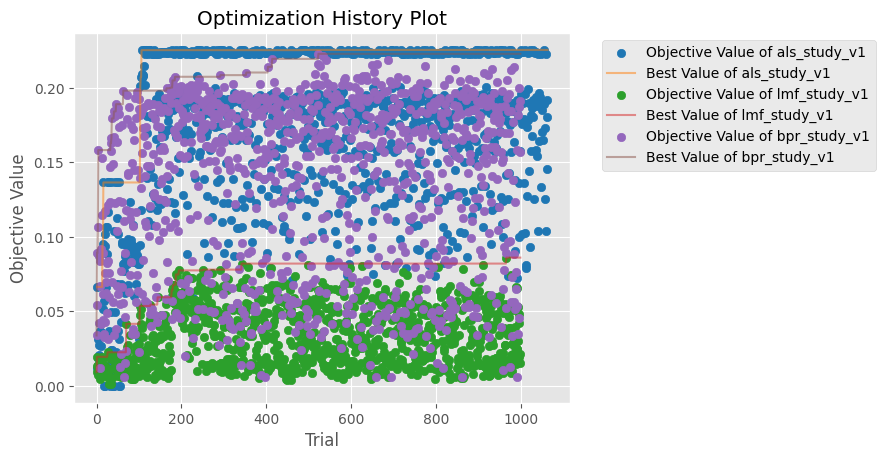

In [34]:
studies = []
for model_id, params in models.items():
    studies.append(optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
                pruner=optuna.pruners.HyperbandPruner(),
                storage="sqlite:///db.sqlite3", # para optuna dashboard
                direction='maximize',
                study_name=f'{params["name"]}_study_v{version}',
                load_if_exists=True))
fig = optuna.visualization.matplotlib.plot_optimization_history(studies)


El plot es confuso por la cantidad de trials, pero se puede observar que el mejor modelo es ALS. Será el que se usara para las pruebas.

A continuación se hace una prueba con los 3 mejores HP de cada modelo.

In [41]:
dfint = make_df_for_implicit(df_int)
stars = make_coo_matrix_from_df(dfint)
stars_train, stars_test = sk.model_selection.train_test_split(stars, test_size=0.2, random_state=42)

best_params_als = models["als"]["best_params"]
model_als = AlternatingLeastSquares(**best_params_als, random_state=42)
model_als.fit(stars_train)
print("Model als:", implicit.evaluation.ndcg_at_k(model_als, stars_train, stars_test, K=5))

best_params_lmf = models["lmf"]["best_params"]
model_lmf = LogisticMatrixFactorization(**best_params_lmf, random_state=42)
model_lmf.fit(stars_train)
print("Model lmf:", implicit.evaluation.ndcg_at_k(model_lmf, stars_train, stars_test, K=5))

best_params_bpr = models["bpr"]["best_params"]
model_bpr = BayesianPersonalizedRanking(**best_params_bpr, random_state=42)
model_bpr.fit(stars_train)
print("Model bpr:", implicit.evaluation.ndcg_at_k(model_bpr, stars_train, stars_test, K=5))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

Model als: 0.30959529387565987


  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

Model lmf: 0.0381476471249576


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/237 [00:00<?, ?it/s]

Model bpr: 0.22955752827321318


Utilizando todo el dataset, podemos observar que el modelo ALS con los mejores Hiperparámetros obtenidos sigue siendo el mejor modelo que tenemos.

# Lightfm

ESTA SECCIÓN NO SE USA

In [27]:
import lightfm as lfm
from lightfm import data, cross_validation, evaluation

## Dataset de LightFM

In [28]:
# genero la codificación de los datasets
ds = lfm.data.Dataset()
ds.fit(users=df_int.user.unique(), items=df_int.repository.unique())
print(ds.interactions_shape())

(12955, 299)


In [29]:
# construyo las interacciones
(lfm_interactions, lfm_weights) = ds.build_interactions(df_int[["user", "repository"]].itertuples(index=False))


## Modelo base


In [30]:
(lfm_train, lfm_test) = lfm.cross_validation.random_train_test_split(lfm_interactions, test_percentage=0.2, random_state=42)
# no aplica porque son likes
#(lfm_train_w, lfm_test_w) = lfm.cross_validation.random_train_test_split(lfm_weights, test_percentage=0.2, random_state=42)

In [33]:
model = lfm.LightFM(no_components=10, k=5, n=10, learning_schedule='adagrad', loss='logistic', learning_rate=0.05, rho=0.95, epsilon=1e-06, item_alpha=0.0, user_alpha=0.0, max_sampled=10, random_state=None)
model.fit(lfm_train,
          #sample_weight=lfm_train_w #no aplica porque son likes
          epochs=64,
          num_threads=8,)

evaluación del modelo base

In [37]:
#lfm.evaluation.precision_at_k(model, test_interactions=lfm_test, train_interactions=lfm_train, k=10, preserve_rows=False, num_threads=8, check_intersections=True)
train_precision = lfm.evaluation.precision_at_k(model, lfm_train, k=10, preserve_rows=False, num_threads=8, check_intersections=True)
test_precision = lfm.evaluation.precision_at_k(model, lfm_test, train_interactions=lfm_train, k=10, preserve_rows=False, num_threads=8, check_intersections=True)

print(train_precision.mean())
print(test_precision.mean())

0.02756283
0.021422774


In [25]:
train_recall = lfm.evaluation.recall_at_k(model, lfm_train, k=10, preserve_rows=False, num_threads=8, check_intersections=True)
test_recall = lfm.evaluation.recall_at_k(model, lfm_test, k=10, preserve_rows=False, num_threads=8, check_intersections=True)

print(train_recall.mean())
print(test_recall.mean())

0.10247229053591395
0.15474207426950504


## Item features

Se agregan features de los items

In [26]:
#len(';'.join([i for i in df_items["topics"].values.tolist() if i is not None]).split(';'))
#len(set(';'.join([i for i in df_items["topics"].values.tolist() if i is not None]).split(';')))
item_features = list(set(';'.join([i for i in df_items["language"].values.tolist() if i is not None]).split(';'))) \
                + list(set(';'.join([i for i in df_items["topics"].values.tolist() if i is not None]).split(';'))) \
                + list(df_items.forks.unique()) \
                + list(df_items.stars.unique())

In [27]:
ds_item_features = lfm.data.Dataset()
ds_item_features.fit(users=df_int.user.unique(), items=df_int.repository.unique(), item_features=item_features)
print(ds_item_features.interactions_shape())

(12955, 298)


Necesito ahora armar una estructura donde para cada item, todas sus features:

```
["repo_1", ["python", "nlp", etc...]]
```

In [28]:
def is_flattened(item):
    if type(item) in [list, tuple]:
        return True
    return False

In [29]:
def flatten(collection):
    flatted_collection = []
    for item in collection:
        if is_flattened(item):
            flatted_collection += flatten(item)
        else:
            flatted_collection.append(item)
    return(flatted_collection)

# test
#l = [1, 2, [3, 4], 5, [6, 7, 8], [9, [10, 11, 12], [13, 14, 15], 16], 17]
#l = flatten(l)
#l == [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] # True

In [30]:
ifs = [] # la lista base que almacenara todos los items
for idx, row in df_items.iterrows():
    #print((row.id, (row.topics.split(";"), row.language.split(";"))))
    topics_splitted = []
    if row.topics is not None:
        topics_splitted = row.topics.split(";")
    
    language_splitted = []
    if row.language is not None:
        language_splitted = row.language.split(";")
    item_f = (
        row.id,
        tuple(
            flatten(
                (topics_splitted,
                 language_splitted,
                 row.forks,
                 row.stars,
                )
            )
        )
    )
    ifs.append(item_f)
item_features = ds_item_features.build_item_features(ifs)
item_features

<298x1948 sparse matrix of type '<class 'numpy.float32'>'
	with 4720 stored elements in Compressed Sparse Row format>

In [31]:
# construyo las interacciones
(lfm_interactions_ifs, lfm_weights_ifs) = ds_item_features.build_interactions(df_int[["user", "repository"]].itertuples(index=False))


In [32]:
#df_items[["id", "forks", "stars", "watchers", "issues", "subscribers"]]
#df_items_lfm = build_dummies(df_items, "language", remove_original_column=True)
#df_items_lfm = build_dummies(df_items_lfm, "topics", remove_original_column=True)
#
#df_items_lfm = df_items_lfm.drop(columns=["about", "es_fork", "archived"], axis=1).shape

In [33]:
(lfm_train_ifs, lfm_test_ifs) = lfm.cross_validation.random_train_test_split(lfm_interactions_ifs, test_percentage=0.2, random_state=42)

model_ifs = lfm.LightFM(no_components=10, k=5, n=10, learning_schedule='adagrad', loss='logistic', learning_rate=0.05, rho=0.95, epsilon=1e-06, item_alpha=0.0, user_alpha=0.0, max_sampled=10, random_state=None)
model_ifs.fit(lfm_train_ifs,
          #sample_weight=lfm_train_w #no aplica porque son likes
          item_features=item_features,
          epochs=64,
          num_threads=8,)

In [34]:
train_precision_ifs = lfm.evaluation.precision_at_k(model_ifs, lfm_train_ifs, item_features=item_features, k=10, preserve_rows=False, num_threads=8, check_intersections=True)
test_precision_ifs = lfm.evaluation.precision_at_k(model_ifs, lfm_test_ifs, item_features=item_features, k=10, preserve_rows=False, num_threads=8, check_intersections=True)

print(train_precision_ifs.mean())
print(test_precision_ifs.mean())

0.005391493
0.0034220533


## User features

-- PENDIENTE --

## Predicción

Prediciendo con todos los datos (e HP optimizados)

In [35]:
import random
random.seed(42)

In [36]:
user_id_map, user_feature_map, item_id_map, item_feature_map = ds_item_features.mapping()
model_pred = lfm.LightFM(no_components=20, random_state=42)
model_pred.fit(lfm_interactions_ifs, item_features=item_features, epochs=10, num_threads=8)

predicciones para un usuario dado, una serie de items elegidos al azar

In [37]:
n = 10
n_items_codes = []
itemized_items = list(item_id_map.items())

# cargo 10 items al azar
for i in range(n):
    n_items_codes.append(random.choice(itemized_items)[1])
n_items_codes

[57, 12, 140, 125, 114, 71, 52, 279, 44, 216]

In [38]:
userid = 'fly51fly'
model_pred.predict(user_id_map[userid], n_items_codes, item_features=item_features)

array([4.323005 , 4.956972 , 5.426517 , 3.765038 , 4.8606863, 4.3323345,
       5.7824683, 3.7510817, 5.373809 , 3.1244197], dtype=float32)

prediccion para un usuario dado de todos los items con los que aún no interactuó

In [39]:
repos_si_vistos = df_int.loc[df_int["user"] == userid, "repository"].tolist()
todos_los_repos = df_items["id"].to_list()

repos_no_vistos = set(todos_los_repos).difference(repos_si_vistos)
predicciones_usuario = model_pred.predict(user_id_map[userid], [item_id_map[item] for item in repos_no_vistos], item_features=item_features)
sorted([(p, i) for (p, i) in zip(predicciones_usuario, repos_no_vistos)], reverse=True)[:10]

[(7.767594, 'fastai/course-nlp'),
 (7.574537, 'apachecn/sklearn-doc-zh'),
 (7.4926605, 'lazyprogrammer/machine_learning_examples'),
 (7.484723, 'dair-ai/ML-Notebooks'),
 (7.350161, 'apachecn/hands-on-ml-zh'),
 (7.3430243, 'rushter/MLAlgorithms'),
 (7.191984, 'jmschrei/pomegranate'),
 (7.1564445, 'rasbt/python-machine-learning-book-3rd-edition'),
 (7.1515603, 'nltk/nltk'),
 (7.136583, 'scikit-learn-contrib/imbalanced-learn')]

pred..

In [40]:
#model_pred.predict_rank(lfm_interactions_ifs, item_features=item_features, num_threads=8)

## Optimización


In [70]:
#def objective_lfm(trial, data):
#    lfm_no_components     = trial.suggest_int('no_components', 100, 1000, step=5)
#    lfm_k                 = trial.suggest_int('k', 5, 8, step=1)
#    lfm_n                 = trial.suggest_int('n', 1, 80, step=1)
#    lfm_loss              = trial.suggest_categorical('loss', ['bpr', 'warp', 'warp-kos'])
#    lfm_learning_rate     = trial.suggest_float('learning_rate', 0.001, 0.01, log=True)
#    #lfm_learning_schedule = trial.suggest_categorical('learning_schedule', ['adagrad', 'adadelta'])
#    #lfm_learning_schedule = trial.suggest_categorical('learning_schedule', ['adagrad'])
#    #lfm_rho               = ""
#    #lfm_epsilon           = ""
#    #lfm_item_alpha        = ""
#    #lfm_user_alpha        = ""
#    #lfm_max_sampled       = ""
#    
#    model = lfm.LightFM(
#        no_components     = lfm_no_components,
#        k                 = lfm_k,
#        n                 = lfm_n,
#        learning_schedule = 'adagrad',
#        loss              = lfm_loss,
#        learning_rate     = lfm_learning_rate,
#        random_state      = 42
#    )
#
#    ## cross validation
#    scores = []
#    for i in range(5):
#        analysis_data, assessment_data = k_fold_split(data, i)
#        model.fit(analysis_data,
#            epochs=64,
#            num_threads=8,)
#        score_all_users = lfm.evaluation.reciprocal_rank(model, assessment_data, train_interactions=analysis_data, num_threads=8)
#        scores.append(np.array(score_all_users).mean())
#    return np.array(scores).mean()

In [71]:
#lfm_study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42),
#                                pruner=optuna.pruners.HyperbandPruner(),
#                                storage="sqlite:///db.sqlite3", # para optuna dashboard
#                                direction='maximize',
#                                study_name='lfm_study_tune',
#                                load_if_exists=True)
#objective_lfm_params = partial(objective_lfm, data=lfm_train)
#lfm_study.optimize(objective_lfm_params, n_trials=2000)

[I 2023-12-25 21:38:32,931] Using an existing study with name 'lfm_study_tune' instead of creating a new one.


[I 2023-12-25 21:38:52,427] Trial 1310 finished with value: 0.10291396081447601 and parameters: {'no_components': 820, 'k': 7, 'n': 6, 'loss': 'bpr', 'learning_rate': 0.00149361065862552}. Best is trial 1256 with value: 0.11814781278371811.
[I 2023-12-25 21:39:11,419] Trial 1311 finished with value: 0.113348089158535 and parameters: {'no_components': 825, 'k': 7, 'n': 14, 'loss': 'warp', 'learning_rate': 0.001498704347600575}. Best is trial 1256 with value: 0.11814781278371811.
[I 2023-12-25 21:39:33,753] Trial 1312 finished with value: 0.11251844465732574 and parameters: {'no_components': 975, 'k': 7, 'n': 14, 'loss': 'warp', 'learning_rate': 0.0015193483592746595}. Best is trial 1256 with value: 0.11814781278371811.
[I 2023-12-25 21:39:39,024] Trial 1313 finished with value: 0.11769841611385345 and parameters: {'no_components': 210, 'k': 7, 'n': 14, 'loss': 'warp', 'learning_rate': 0.0015256929433527528}. Best is trial 1256 with value: 0.11814781278371811.
[I 2023-12-25 21:39:50,403]

KeyboardInterrupt: 

# Uso de embeddings

Esta sección no se usa

[Video](https://www.youtube.com/watch?v=zKM-PUEbR3A)

In [41]:
con = sqlite3.connect(os.path.join(THIS_FOLDER, "data/data.db"))
df_int_con_fecha = pd.read_sql_query(f"SELECT repository, user, date FROM {interacciones}", con, parse_dates=["date"])
con.close()

df_int_con_fecha["year"] = df_int_con_fecha["date"].dt.year
df_int_con_fecha["month"] = df_int_con_fecha["date"].dt.month
df_int_con_fecha["day"] = df_int_con_fecha["date"].dt.day
df_int_con_fecha["dayofweek"] = df_int_con_fecha["date"].dt.dayofweek

df_int_con_fecha = df_int_con_fecha.drop(columns=["date"])

df_int_con_fecha.head()

,repository,user,year,month,day,dayofweek
0,tensorflow/tensorflow,mrry,2015,11,9,0
1,tensorflow/tensorflow,danbri,2015,11,9,0
2,tensorflow/tensorflow,rockt,2015,11,9,0
3,tensorflow/tensorflow,petro-rudenko,2015,11,9,0
4,huggingface/transformers,kashif,2018,11,5,0


## Versión con dummies

In [42]:
#df_int_con_fecha.shape
#len(df_int_con_fecha.repository.unique())
#len(df_int_con_fecha.user.unique())

df_dummies = pd.get_dummies(df_int_con_fecha, columns=["repository", "user", "dayofweek"])
df_dummies["like"] = 1

In [43]:
max_year = df_dummies.year.unique().max()
train = df_dummies[df_dummies["year"] < max_year]
test = df_dummies[df_dummies["year"] >= max_year]
train.shape, test.shape

((20269, 13264), (1757, 13264))

In [44]:
X_train = train[train.columns.drop('like')]
y_train = train['like']
X_test = test[test.columns.drop('like')]
y_test = test['like']

model = sk.ensemble.RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=8, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=8, random_state=42)

In [45]:
y_pred = model.predict(X_test)
sk.metrics.precision_score(y_test, y_pred)

1.0

Esto no funciona por el tipo del dataset. Mejor vamos a cambiar el enfoque

## Embeddings con campo about

In [47]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Assuming 'df' is your DataFrame and 'sentence' is the column with sentences
sentences = df_items.about.tolist()

# Generate embeddings for sentences
embeddings = model.encode(sentences, convert_to_tensor=True)

# Convert embeddings to a DataFrame
embedding_df = pd.DataFrame(embeddings.cpu().numpy(), columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

# Concatenate the original DataFrame with the embedding DataFrame
df_items = pd.concat([df_items, embedding_df], axis=1)


In [52]:
item_features = list(set(';'.join([i for i in df_items["language"].values.tolist() if i is not None]).split(';'))) \
                + list(set(';'.join([i for i in df_items["topics"].values.tolist() if i is not None]).split(';'))) \
                + list(df_items.forks.unique()) \
                + list(df_items.stars.unique())

In [55]:
for col in embedding_df:
    item_features = item_features + list(embedding_df[col].unique())

In [57]:
item_features

<298x101329 sparse matrix of type '<class 'numpy.float32'>'
	with 4720 stored elements in Compressed Sparse Row format>

In [56]:
ds_item_features = lfm.data.Dataset()
ds_item_features.fit(users=df_int.user.unique(), items=df_int.repository.unique(), item_features=item_features)
print(ds_item_features.interactions_shape())

ifs = [] # la lista base que almacenara todos los items
for idx, row in df_items.iterrows():
    #print((row.id, (row.topics.split(";"), row.language.split(";"))))
    topics_splitted = []
    if row.topics is not None:
        topics_splitted = row.topics.split(";")
    
    language_splitted = []
    if row.language is not None:
        language_splitted = row.language.split(";")
    item_f = (
        row.id,
        tuple(
            flatten(
                (topics_splitted,
                 language_splitted,
                 row.forks,
                 row.stars,
                )
            )
        )
    )
    ifs.append(item_f)
item_features = ds_item_features.build_item_features(ifs)
item_features

(lfm_interactions_ifs, lfm_weights_ifs) = ds_item_features.build_interactions(df_int[["user", "repository"]].itertuples(index=False))

(lfm_train_ifs, lfm_test_ifs) = lfm.cross_validation.random_train_test_split(lfm_interactions_ifs, test_percentage=0.2, random_state=42)

model_ifs = lfm.LightFM(no_components=10, k=5, n=10, learning_schedule='adagrad', loss='logistic', learning_rate=0.05, rho=0.95, epsilon=1e-06, item_alpha=0.0, user_alpha=0.0, max_sampled=10, random_state=None)
model_ifs.fit(lfm_train_ifs,
          #sample_weight=lfm_train_w #no aplica porque son likes
          item_features=item_features,
          epochs=64,
          num_threads=8,)

train_precision_ifs = lfm.evaluation.precision_at_k(model_ifs, lfm_train_ifs, item_features=item_features, k=10, preserve_rows=False, num_threads=8, check_intersections=True)
test_precision_ifs = lfm.evaluation.precision_at_k(model_ifs, lfm_test_ifs, item_features=item_features, k=10, preserve_rows=False, num_threads=8, check_intersections=True)

print(train_precision_ifs.mean())
print(test_precision_ifs.mean())


(12955, 298)
0.005391493
0.0034220533


## Otra versión de embeddings